In [1]:
import pandas as pd
from pandas import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [90]:
data = pd.read_csv('data/bitcoin_USD_close_data-2017-02-05_2018-02-05.csv',
                   parse_dates=['Date'])
print(data.shape)
data.tail()

(366, 2)


,Date,Price
361,2018-02-01 00:00:00,9052.58
362,2018-02-02 00:00:00,8827.63
363,2018-02-03 00:00:00,9224.39
364,2018-02-04 00:00:00,8186.65
365,2018-02-05 18:21:00,6953.94


In [91]:
data['Date'] = data['Date'].dt.date
data.set_index(pd.to_datetime(data['Date']), inplace=True)
data.drop('Date', axis=1, inplace=True)
data.head()

,Price
Date,
2017-02-05,1013.99
2017-02-06,1024.61
2017-02-07,1052.54
2017-02-08,1054.34
2017-02-09,988.95


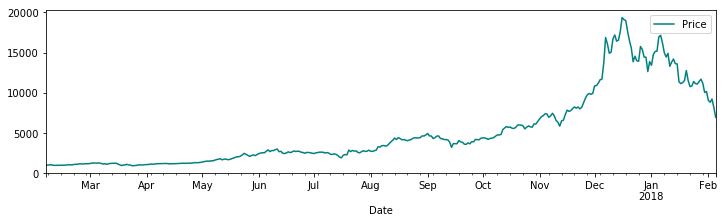

In [92]:
data.plot(y='Price', color='teal', figsize=(12,3))

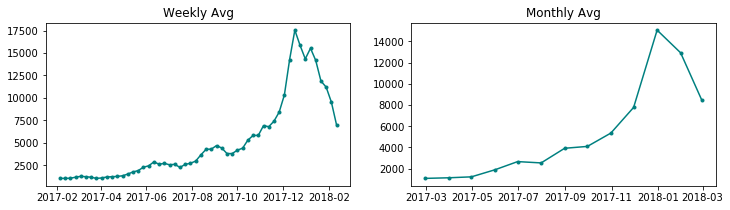

In [93]:
price_weekly_avg = data.resample('W').apply(np.mean)
price_monthly_avg = data.resample('M').apply(np.mean)
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.Price, "-o", markersize=3, color='teal')
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.Price, "-o", markersize=3, color='teal')

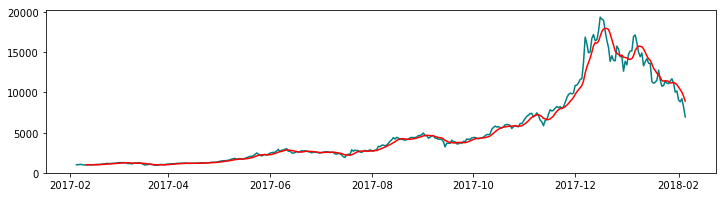

In [94]:
rolling_mean = data.Price.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 
plt.figure(figsize=(12,3))
plt.plot(data.Price, color='teal')
plt.plot(rolling_mean, 'red') 

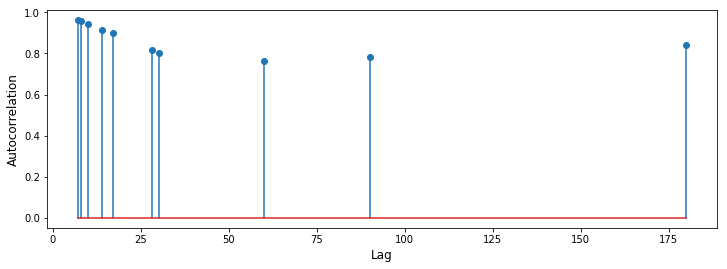

In [68]:
lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180] 
autocorrs = [data.Price.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
#the greatest correlations seems to be rpoduced from lag of 7, meaning our data has weekly seasonality. 

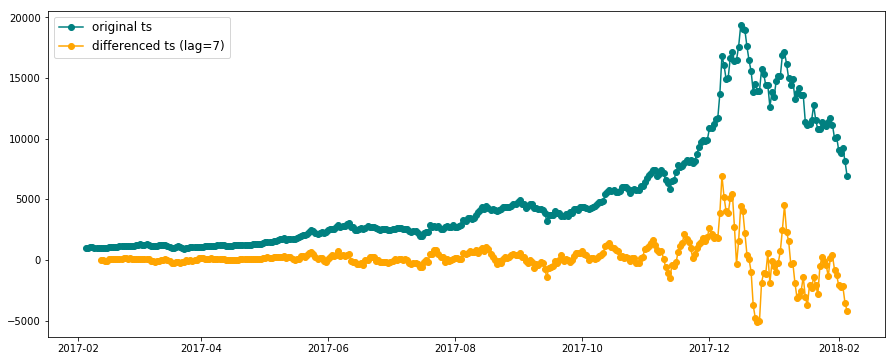

In [69]:
plt.figure(figsize=(15, 6))
plt.plot(data.Price, '-o', color='teal', label="original ts")
plt.plot(data.Price.diff(7), '-o', color='orange', label="differenced ts (lag=7)")
plt.legend(fontsize=12)


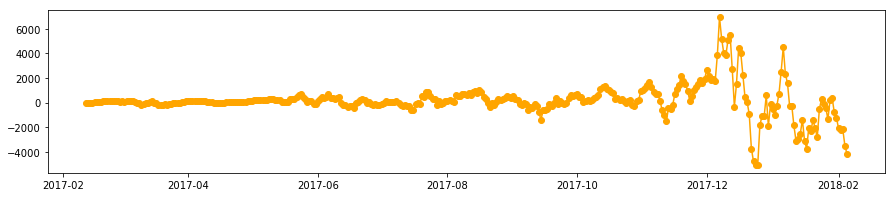

In [71]:
prices = data.Price
price_diff = prices.diff(7).dropna() 

plt.figure(figsize=(15,3))
plt.plot(price_diff, "-o", color='orange')

Above figure seems stationary enough so optlag=7 chosen for following operations

In [72]:
time_series = price_diff #time series with diff of 7 as from autocorrelation 7 seems to be the best one (data very correlated 
# every 7 days)

#### Now lets try with SKLearn linearRegression and then AR and ARMA models (time_series has not changed still diff =7)

In [73]:
#this is kind of redundant as optlag from autocorrelation seems to be 7. so am doing this cell only as exploration
ar = tsa.AR(time_series)
optlag = ar.select_order(31, ic='aic') #'bic' gave better prediction than 'aic'. Nonetheless Im manually adding the desired lag, 
#so far 90 gives the least MAE but its not considering the first 90 points so maybe thats why its MAE is lower
print("Best optimal lag: {}".format(optlag))

Best optimal lag: 31


MAE = 234.965
MAE2 = 320.540


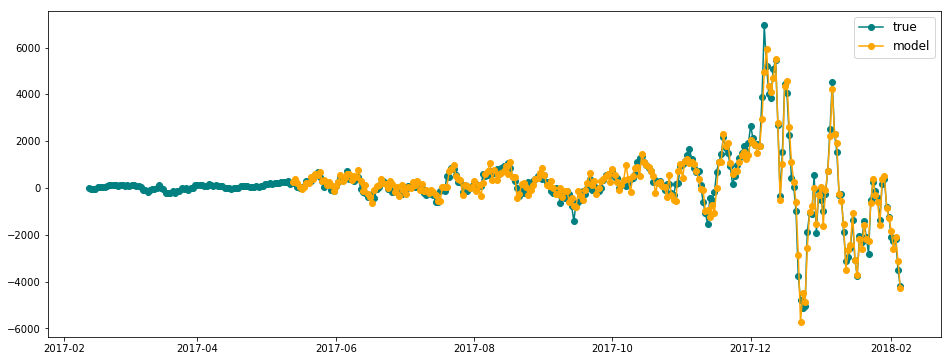

In [74]:
#optlag of 7 seems to be the best from autocorr, but am checking different ones here to compare their MAE
optlag = 90
ar_fit = ar.fit(maxlag=optlag, ic='aic')
ar_prediction = ar_fit.predict(start=optlag)

plt.figure(figsize=(16, 6))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[optlag:], ar_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-100:], ar_prediction[-100:]))) #error only for the last 90 days


For doing a linear regression on time series we need to organize the data with matrix X where each row contains a forecast windiw and y is the target values for each row of X.

In [76]:
def organize_data(to_forecast, window, horizon=1):
    
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

optlag = 90
X, y = organize_data(time_series, optlag)

MAE = 234.974
MAE2 = 320.080


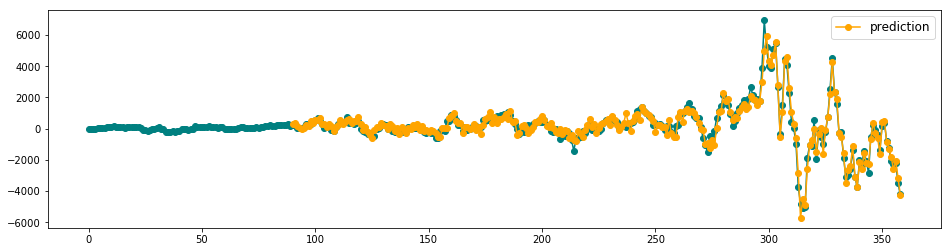

In [77]:
lr = LinearRegression()
lr_fit = lr.fit(X, y)
lr_prediction = lr_fit.predict(X)

plt.figure(figsize=(16, 4))
plt.plot(time_series.values, '-o', color='teal')
plt.plot(np.arange(optlag, len(time_series)), lr_prediction, '-o', label='prediction', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[optlag:], lr_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-100:], lr_prediction[-100:]))) #for the last 90 days only

Trying an ARMA model

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MAE = 240.080


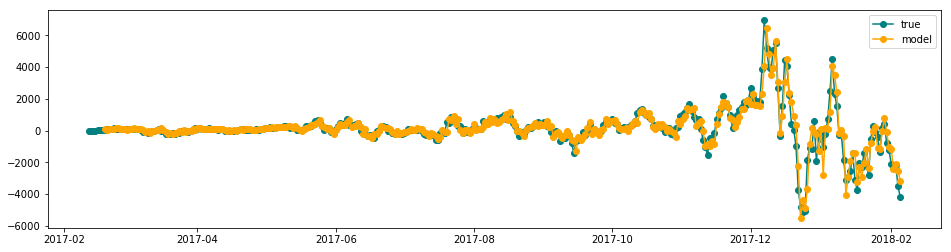

In [78]:
arma = tsa.ARMA(time_series, order=(7, 7)) #7 p and 7 q for lag and moving average 
arma_fit = arma.fit()
arma_prediction = arma_fit.predict(start=7)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[7:], arma_prediction)))


### Now out of sample forcasting (the next 7 days)

In [79]:
train = time_series[:-7]
test = time_series[-7:]

In [80]:
#7 out of sample prediction with AR 
ar = tsa.AR(time_series)
optlag = 7
ar_fit = ar.fit(maxlag=optlag)
ar_forecast = ar_fit.predict(end=len(time_series)+6)[-len(test):] 
ar_forecast

2018-02-06   -3848.560183
2018-02-07   -3111.500416
2018-02-08   -2366.143891
2018-02-09   -2282.588548
2018-02-10   -1980.107008
2018-02-11   -1345.265911
2018-02-12    -829.096123
Freq: D, dtype: float64

In [81]:
#7 out of sample prediction with ARMA
arma = tsa.ARMA(time_series, order=(7, 7)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+6)[-len(test):]
arma_forecast

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2018-02-06   -3712.606667
2018-02-07   -3322.188377
2018-02-08   -2306.090321
2018-02-09   -2693.449649
2018-02-10   -2749.805171
2018-02-11   -1634.531144
2018-02-12   -1432.401240
Freq: D, dtype: float64

In [82]:
#and here ARIMA which basically gives same thing as ARMA but in a different way. 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(time_series, order=(7,0,7))
arima_fit = model.fit()
arima_forecast= arima_fit.forecast(steps=7)[0]
arima_forecast

C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\ndadkhah\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


array([-3712.60666694, -3322.18837701, -2306.0903213 , -2693.44964876,
       -2749.80517052, -1634.53114376, -1432.40123995])

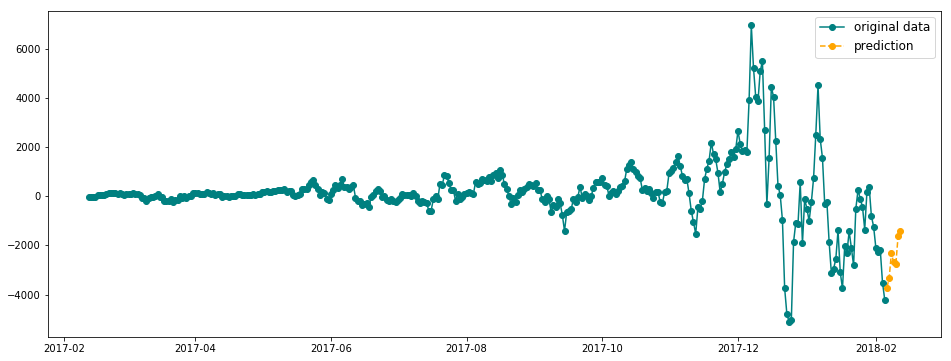

In [83]:
plt.figure(figsize=(16, 6))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)


### Now we need to find the actual next 7 out of sample values by adding each predicted diff value to the actual price 7 days before them 

In [85]:
print(prices[-7:]) #the actual last 7 sample prices

Date
2018-01-30    10035.00
2018-01-31    10166.51
2018-02-01     9052.58
2018-02-02     8827.63
2018-02-03     9224.39
2018-02-04     8186.65
2018-02-05     6953.94
Name: Price, dtype: float64


In [88]:
idx = arma_forecast.index.values

forecast_prices = []
lag = 7
for i, diff in enumerate(arma_forecast): #choosing ARMA as it produced lower MAE than AR model
    prev_value = prices[-(lag)+i:][0]
    forecast_prices.append(prev_value+diff)
    
bitcoin_forecast = pd.Series(forecast_prices, index=idx)
bitcoin_forecast

2018-02-06    6322.393333
2018-02-07    6844.321623
2018-02-08    6746.489679
2018-02-09    6134.180351
2018-02-10    6474.584829
2018-02-11    6552.118856
2018-02-12    5521.538760
dtype: float64

<function matplotlib.pyplot.show>

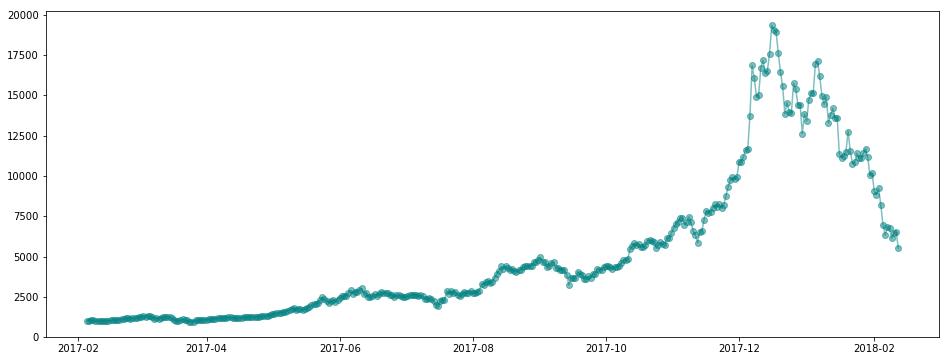

In [89]:
hist_values = data['Price'].append(bitcoin_forecast)

plt.figure(figsize=(16,6))
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show